# Denoising filters

![Task](pics/task.jpg)

In [222]:
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import numpy as np
import math
import pandas as pd
%matplotlib inline
def sns_set(with_grid = False):
    sns.set()
    sns.set_style("whitegrid", {'axes.grid' : with_grid})

In [2]:
def sad(a, b):
    return np.mean(np.abs(a.astype(np.float64) - b.astype(np.float64)))

def noised(img, sigma=1) :
    noise = np.random.normal(0, sigma, size=img.shape)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

In [3]:
tower = cv.imread('pics/tower.jpg', 0)

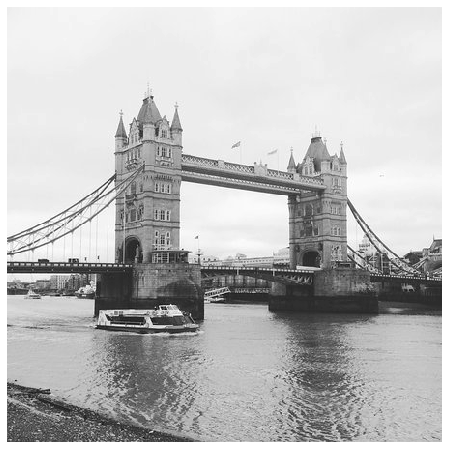

In [336]:
sns_set(False)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower, cmap='gray')

In [5]:
tower_noisy = noised(tower, sigma=10)
sad(tower, tower_noisy)

7.84715061728395

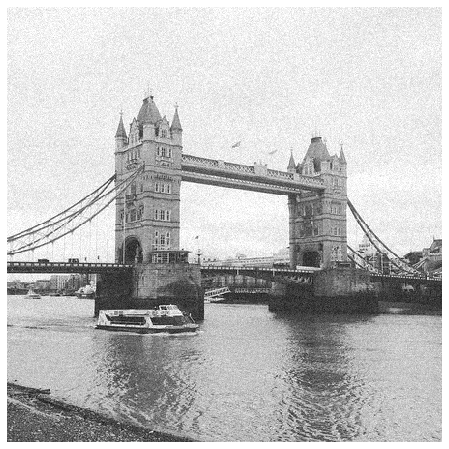

In [337]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_noisy, cmap='gray')
plt.savefig('pics/tower_noisy')

# Gaussian filter

In [474]:
def gaussian(v, sigma):
    return np.exp(-(v ** 2) / (2 * sigma ** 2)) / np.sqrt(2 * math.pi * sigma)

def gauss(x, y, sigma):
    return math.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / (2 * math.pi * sigma)

def gauss_kernel(sigma, size=None):
    K = round(4 * sigma + 1) if size is None else size
    K = np.uint8(K)
    kernel = np.zeros((K, K))
    for i in np.arange(K):
        for j in np.arange(K):
            kernel[i, j] = gauss(i - K // 2, j - K // 2, sigma)
    return kernel / kernel.sum()

def gauss_filter(img, sigma):
    return cv.filter2D(img, 0, gauss_kernel(sigma))

In [475]:
sigma = np.arange(0.2, 3.0, 0.2)
sigma

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
       2.8])

In [476]:
tower_gauss = [gauss_filter(tower_noisy, s) for s in sigma]
sads = [sad(tower, t) for t in tower_gauss]
list(zip(sigma, sads))

[(0.2, 7.84715061728395),
 (0.4, 6.835328395061729),
 (0.6000000000000001, 6.176577777777778),
 (0.8, 6.776676543209876),
 (1.0, 7.399170370370371),
 (1.2, 7.858306172839506),
 (1.4000000000000001, 8.27839012345679),
 (1.6, 8.590449382716049),
 (1.8, 8.901432098765433),
 (2.0, 9.224479012345679),
 (2.2, 9.493451851851852),
 (2.4000000000000004, 9.77346172839506),
 (2.6000000000000005, 9.964804938271605),
 (2.8000000000000003, 10.193432098765433)]

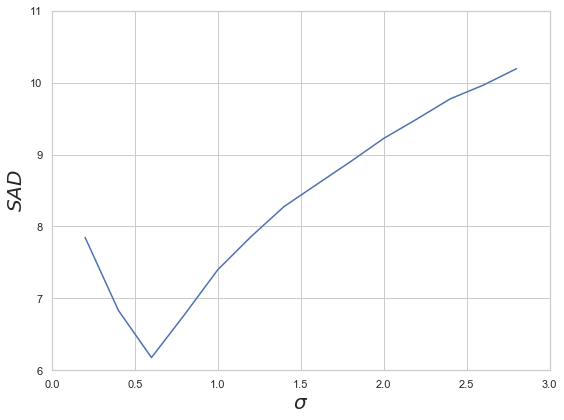

In [488]:
sns_set(True)
plt.figure(figsize=(8, 6))
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('$SAD$', fontsize=20)
plt.ylim(6, 11)
plt.xlim(0, 3)
plt.tight_layout()
plt.plot(sigma, sads)
plt.savefig('pics/tower_gauss_tune')

In [478]:
tower_gauss_best = tower_gauss[2]

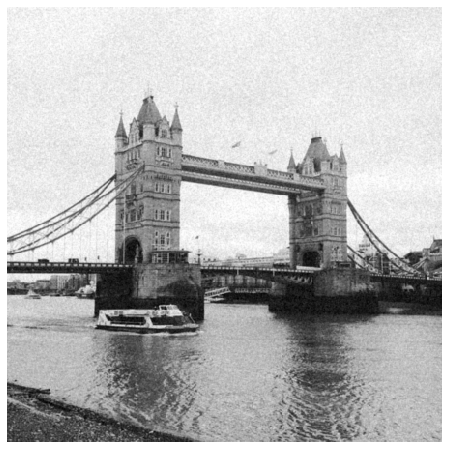

In [480]:
sns_set(False)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_gauss_best, cmap='gray')

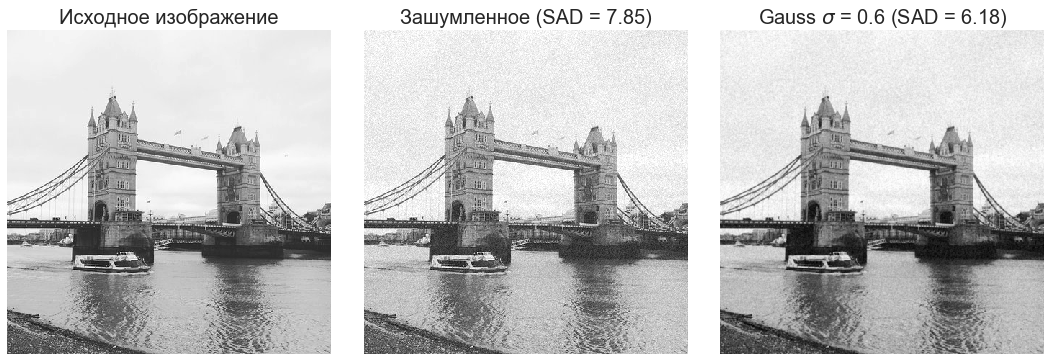

In [487]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].axis('off')
axes[0].imshow(tower, cmap='gray')
axes[0].set_title('Исходное изображение', fontsize=20)

axes[1].axis('off')
axes[1].imshow(tower_noisy, cmap='gray')
axes[1].set_title('Зашумленное (SAD = %.2f)' % sad(tower, tower_noisy), fontsize=20)

axes[2].axis('off')
axes[2].imshow(tower_gauss_best, cmap='gray')
axes[2].set_title('Gauss $\sigma$ = %.1f (SAD = %.2f)' % (sigma[2], sad(tower, tower_gauss_best)), fontsize=20)

plt.tight_layout()
plt.savefig('pics/tower_gauss')

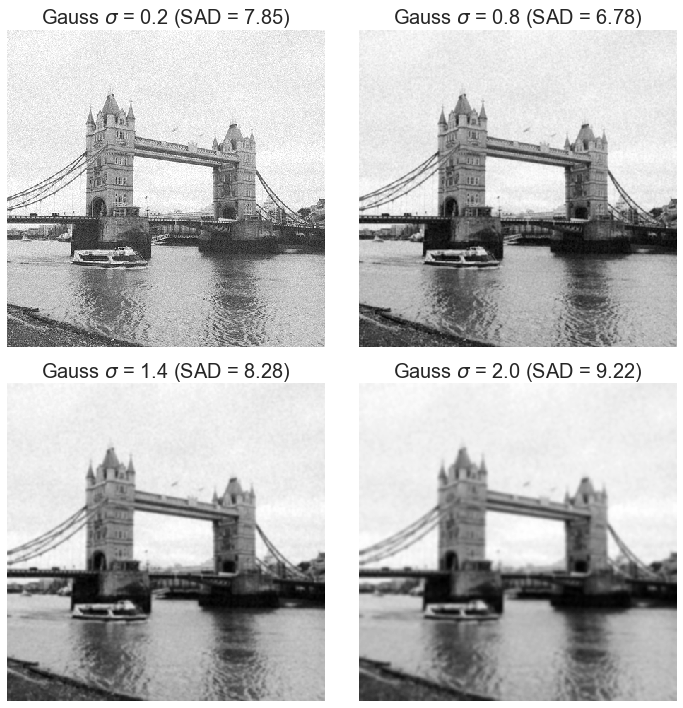

In [489]:
def draw(ax, image, sigma):
    ax.axis('off')
    ax.imshow(image, cmap='gray')
    ax.set_title('Gauss $\sigma$ = %.1f (SAD = %.2f)' % (sigma, sad(tower, image)), fontsize=20)
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

draw(axes[0][0], tower_gauss[0], sigma[0])
draw(axes[0][1], tower_gauss[3], sigma[3])
draw(axes[1][0], tower_gauss[6], sigma[6])
draw(axes[1][1], tower_gauss[9], sigma[9])

plt.tight_layout()
plt.savefig('pics/tower_gauss_compare')

# Bilateral filter

In [36]:
def bilateral_filter(img, sigma_s, sigma_r):
    n_neig = sigma_s * 2 + 1
    print('Startring', sigma_s, sigma_r, n_neig, end='... ')
    result = np.zeros_like(img, dtype=np.float64)
    img_pad = np.pad(img, n_neig, mode='reflect').astype(np.float64)
    for i in range(n_neig, img.shape[0] + n_neig):
        if i % 10 == 0: print(i, end=' ')
        for j in range(n_neig, img.shape[1] + n_neig):
            region = img_pad[(i - n_neig) : (i + n_neig + 1), (j - n_neig) : (j + n_neig + 1)]
            space_weights = gauss_kernel(sigma_s, size=(n_neig * 2 + 1))
            range_weights = gaussian(region - img_pad[i, j], sigma_r)
            weights = space_weights * range_weights
            result[i - n_neig, j - n_neig] = np.sum(region * weights) / weights.sum()
    return np.clip(result, 0, 255).astype(np.uint8)

In [356]:
sigma_s = np.arange(1, 11, 3)
sigma_r = np.arange(1, 11, 3)
sigma_s, sigma_r

(array([ 1,  4,  7, 10]), array([ 1,  4,  7, 10]))

In [40]:
tower_bilateral = [[s, r, bilateral_filter(tower_noisy, s, r)] for s in sigma_s for r in sigma_r]

Startring 1 1 3... 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 Startring 1 4 3... 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 Startring 1 7 3... 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 Startring 1 10 3... 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 Startring 4 1 9... 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 Startring 4 4 9... 10 20 30 40 50 60 70 80 90 100

In [390]:
tower_bilaterals = np.array(list(map(lambda x: np.array([x[0], x[1], sad(tower, x[2])]), tower_bilateral)))
tower_bilaterals_df = pd.DataFrame(tower_bilaterals, columns=['sigma_s', 'sigma_r', 'sad'])
tower_bilaterals_df

sigma_s  sigma_r       sad
0       1.0      1.0  7.833081
1       1.0      4.0  7.562138
2       1.0      7.0  6.867240
3       1.0     10.0  6.109407
4       4.0      1.0  7.801160
5       4.0      4.0  7.275299
6       4.0      7.0  6.324988
7       4.0     10.0  5.462672
8       7.0      1.0  7.763185
9       7.0      4.0  7.265541
10      7.0      7.0  6.337936
11      7.0     10.0  5.503872
12     10.0      1.0  7.733793
13     10.0      4.0  7.271072
14     10.0      7.0  6.370059
15     10.0     10.0  5.557116

In [316]:
np.savetxt('data/bilateral.csv', tower_bilaterals_df)

In [333]:
tower_bilateral_best = tower_bilateral[tower_bilaterals_df['sad'].idxmin()][2]
sad(tower, tower_bilateral_best)

5.462671604938271

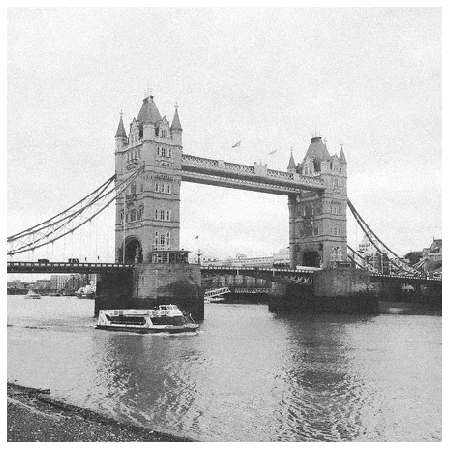

In [460]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_bilateral_best, cmap='gray')

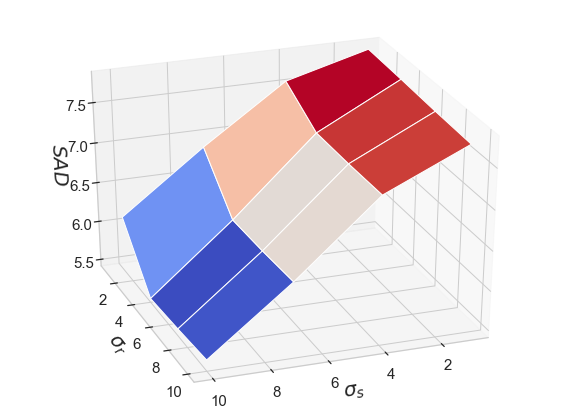

In [396]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 70)
x, y = np.meshgrid(sigma_s, sigma_r)
ax.plot_surface(x, y, tower_bilaterals[:, 2].reshape((4, 4)), cmap=plt.cm.coolwarm)
ax.set_xlabel('$\sigma_{s}$', fontsize=20)
ax.set_ylabel('$\sigma_{r}$', fontsize=20)
ax.set_zlabel('$SAD$', fontsize=20, rotation='horizontal')
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('pics/tower_bilateral_tune')

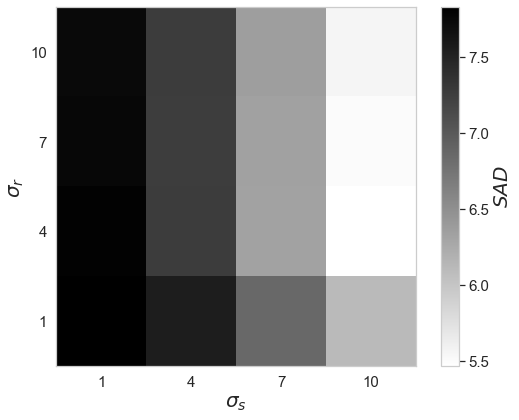

In [404]:
plt.figure(figsize=(8, 6))
plt.subplot(111)
plt.imshow(tower_bilaterals[:, 2].reshape((4, 4)), aspect='equal', cmap='binary', origin='lower')
plt.xlabel('$\sigma_s$', fontsize=20)
plt.xticks(range(len(sigma_s)), labels=sigma_s, fontsize=15)
plt.ylabel('$\sigma_r$', fontsize=20)
plt.yticks(range(len(sigma_r)), labels=sigma_r, fontsize=15)
cbar = plt.colorbar(fraction=0.037, pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$SAD$', fontsize=20)
plt.tight_layout()
plt.savefig('pics/tower_bilateral_tune')

In [45]:
tower_bilateral_cv = cv.bilateralFilter(tower_noisy, -1, 10, 10)
sad(tower, tower_bilateral_cv)

5.473145679012346

In [46]:
sad(tower_bilateral[15][2], tower_bilateral_cv) # very close to opencv

0.5225777777777778

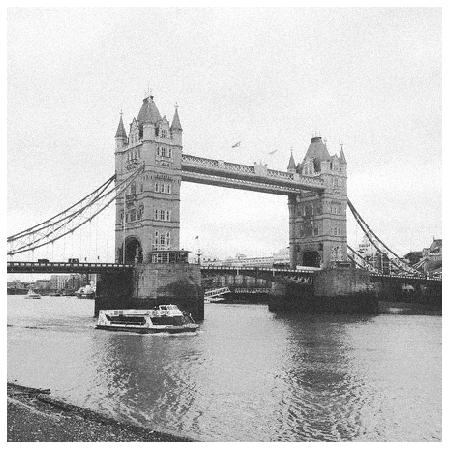

In [459]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_bilateral_cv, cmap='gray')

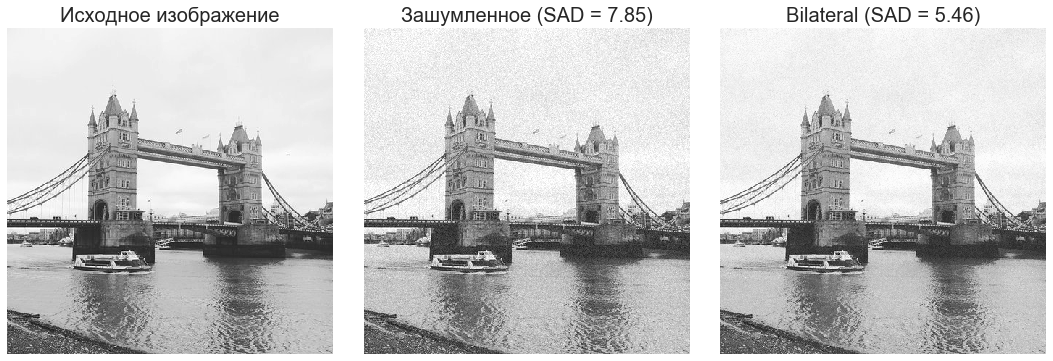

In [458]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].axis('off')
axes[0].imshow(tower, cmap='gray')
axes[0].set_title('Исходное изображение', fontsize=20)

axes[1].axis('off')
axes[1].imshow(tower_noisy, cmap='gray')
axes[1].set_title('Зашумленное (SAD = %.2f)' % sad(tower, tower_noisy), fontsize=20)

axes[2].axis('off')
axes[2].imshow(tower_bilateral_best, cmap='gray')
axes[2].set_title('Bilateral (SAD = %.2f)' % sad(tower, tower_bilateral_best), fontsize=20)

plt.tight_layout()
plt.savefig('pics/tower_bilateral')

In [ ]:
def draw(ax, image, sigma):
    ax.axis('off')
    ax.imshow(image, cmap='gray')
    ax.set_title('Gauss $\sigma$ = %.1f (SAD = %.2f)' % (sigma, sad(tower, image)), fontsize=20)
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

draw(axes[0][0], tower_gauss[0], sigma[0])
draw(axes[0][1], tower_gauss[3], sigma[3])
draw(axes[1][0], tower_gauss[6], sigma[6])
draw(axes[1][1], tower_gauss[9], sigma[9])

plt.tight_layout()

# Non-local means (NLM)

In [48]:
# http://dsvision.github.io/an-approach-to-non-local-means-denoising.html

In [188]:
def nlm_local(img, x, y, sigma_r, n_comp, n_neig):
    height, width = img.shape
    value, wp = 0, 0
    
    values = img[(x - n_neig):(x + n_neig + 1), (y - n_neig):(y + n_neig + 1)]
    template = img[(x - n_comp):(x + n_comp + 1), (y - n_comp):(y + n_comp + 1)]
    weight = lambda x: gaussian(sad(template, x), sigma_r)
    
    weights = np.reshape([
        weight(img[(i - n_comp) : (i + n_comp + 1), (j - n_comp) : (j + n_comp + 1)]) \
        for i in np.arange(x - n_neig, x + n_neig + 1) \
        for j in np.arange(y - n_neig, y + n_neig + 1)], values.shape)
    
    res = np.sum(values * weights) / weights.sum()
    return res

def nlm_filter(img, sigma_r, n_comp, n_neig):
    print('Startring', sigma_r, n_comp, n_neig, end='... ')
    n_comp_half = n_comp // 2
    n_neig_half = n_neig // 2
    pad = n_comp_half + n_neig_half
    img_pad = np.pad(img, pad, mode='reflect').astype(np.float64)
    result = np.zeros_like(img, np.float64)
    for i in np.arange(pad, img.shape[0] + pad):
        #if i % 10 == 0: print(i, end=' ')
        for j in np.arange(pad, img.shape[1] + pad):
            result[i - pad, j - pad] = nlm_local(img_pad, i, j, sigma_r, n_comp_half, n_neig_half)
    return np.clip(0, 255, result).astype(np.uint8)

In [160]:
tower_nlm = nlm_filter(tower_noisy, 10, 3, 3)

Startring 10 3 3... 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 

In [238]:
sad(tower, tower_nlm)

4.690720987654321

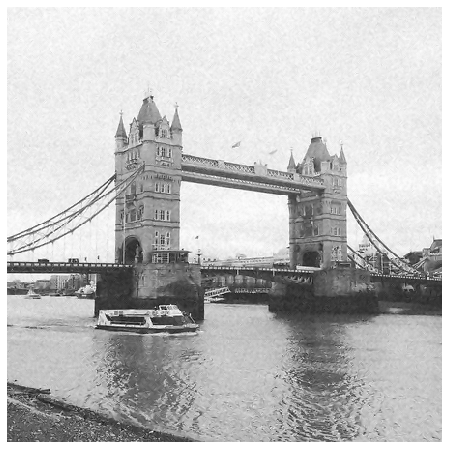

In [324]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_nlm, cmap='gray')

In [179]:
sigma_r = np.arange(5, 21, 5)
n_comp = np.arange(3, 12, 4)
n_neig = np.arange(5, 18, 4)
sigma_r, n_comp, n_neig

(array([ 5, 10, 15, 20]), array([ 3,  7, 11]), array([ 5,  9, 13, 17]))

In [180]:
tower_nlms = [[s, c, n, cv.fastNlMeansDenoising(tower_noisy, None, s, c, n)] for s in sigma_r for c in n_comp for n in n_neig]

In [229]:
tower_nlms_sad = list(map(lambda x: [x[0], x[1], x[2], sad(tower, x[3])], tower_nlms))
tower_nlms_df = pd.DataFrame(tower_nlms_sad, columns=['sigma_r', 'n_comp', 'n_neig', 'sad'])
tower_nlms_df

sigma_r  n_comp  n_neig       sad
0         5       3       5  7.470528
1         5       3       9  7.039215
2         5       3      13  6.702948
3         5       3      17  6.460751
4         5       7       5  7.763723
5         5       7       9  7.578968
6         5       7      13  7.373254
7         5       7      17  7.179106
8         5      11       5  7.808968
9         5      11       9  7.696800
10        5      11      13  7.563881
11        5      11      17  7.434914
12       10       3       5  4.883407
13       10       3       9  4.272593
14       10       3      13  4.093965
15       10       3      17  4.030484
16       10       7       5  4.752578
17       10       7       9  4.194696
18       10       7      13  4.054904
19       10       7      17  4.017536
20       10      11       5  4.838010
21       10      11       9  4.321728
22       10      11      13  4.203220
23       10      11      17  4.177032
24       15       3       5  4.176864
25       15       3       9  3.973417
26       15       3      13  4.007862
27       15       3      17  4.090840
28       15       7       5  4.159570
29       15       7       9  4.049640
30       15       7      13  4.127956
31       15       7      17  4.234123
32       15      11       5  4.242326
33       15      11       9  4.126267
34       15      11      13  4.209136
35       15      11      17  4.316706
36       20       3       5  4.395274
37       20       3       9  4.491620
38       20       3      13  4.660810
39       20       3      17  4.819007
40       20       7       5  4.500810
41       20       7       9  4.812983
42       20       7      13  5.152143
43       20       7      17  5.447837
44       20      11       5  4.589417
45       20      11       9  4.934593
46       20      11      13  5.309383
47       20      11      17  5.623269

In [317]:
np.savetxt('data/nlm.csv', tower_nlms_df)

In [415]:
tower_nlm_best = tower_nlms[tower_nlms_df['sad'].idxmin()]
tower_nlm_best[0], tower_nlm_best[1], tower_nlm_best[2], sad(tower, tower_nlm_best[3])

(15, 3, 9, 3.973417283950617)

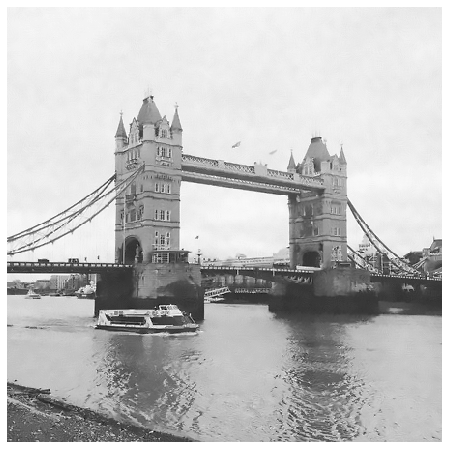

In [456]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_nlm_best[3], cmap='gray')

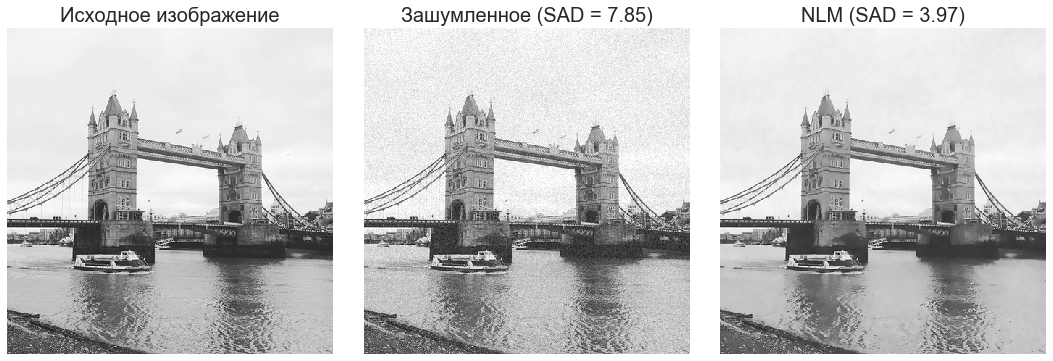

In [457]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].axis('off')
axes[0].imshow(tower, cmap='gray')
axes[0].set_title('Исходное изображение', fontsize=20)

axes[1].axis('off')
axes[1].imshow(tower_noisy, cmap='gray')
axes[1].set_title('Зашумленное (SAD = %.2f)' % sad(tower, tower_noisy), fontsize=20)

axes[2].axis('off')
axes[2].imshow(tower_nlm_best[3], cmap='gray')
axes[2].set_title('NLM (SAD = %.2f)' % sad(tower, tower_nlm_best[3]), fontsize=20)

plt.tight_layout()
plt.savefig('pics/tower_nlm')

In [429]:
tower_nlms_sigma15 = tower_nlms_df[tower_nlms_df['sigma_r'] == 15]['sad'].values
tower_nlms_sigma15

array([4.1768642 , 3.97341728, 4.00786173, 4.09083951, 4.15957037,
       4.04963951, 4.12795556, 4.23412346, 4.24232593, 4.12626667,
       4.2091358 , 4.31670617])

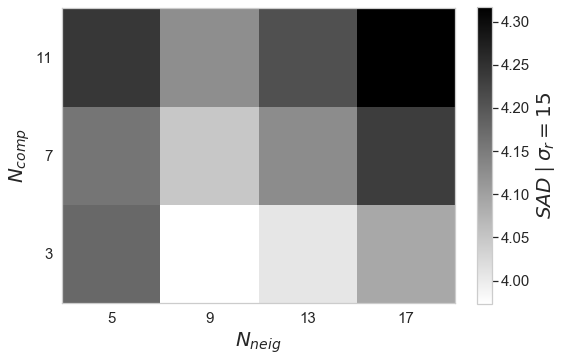

In [430]:
plt.figure(figsize=(8, 6))
plt.subplot(111)
plt.imshow(tower_nlms_sigma15.reshape((3, 4)), aspect='equal', cmap='binary', origin='lower')
plt.ylabel('$N_{comp}$', fontsize=20)
plt.yticks(range(len(n_comp)), labels=n_comp, fontsize=15)
plt.xlabel('$N_{neig}$', fontsize=20)
plt.xticks(range(len(n_neig)), labels=n_neig, fontsize=15)
cbar = plt.colorbar(fraction=0.0345, pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$SAD$ | $\sigma_r=15$', fontsize=20)
plt.tight_layout()
plt.savefig('pics/tower_nlm_tune')

In [433]:
sad(tower, tower_nlm_best[3]), sad(tower, tower_gauss[3]), sad(tower, tower_bilateral[15][2])

(3.973417283950617, 6.776676543209876, 5.557116049382716)

In [434]:
tower_nlm_cv = cv.fastNlMeansDenoising(tower_noisy, None, 10, 7, 17)

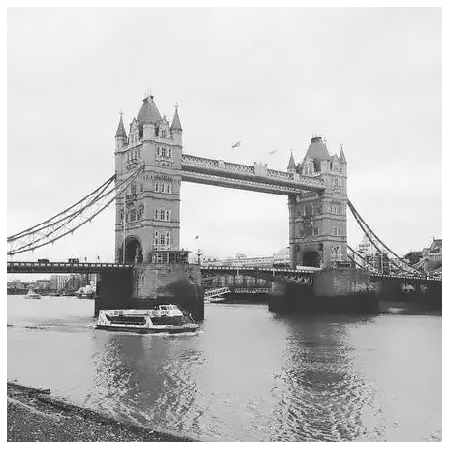

In [435]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(tower_nlm_cv, cmap='gray')
plt.savefig('pics/tower_nlm_cv')

In [437]:
sad(tower, tower_nlm_best[3]), sad(tower, tower_nlm_cv), sad(tower_nlm_cv, tower_nlm_best[3])

(3.973417283950617, 4.017535802469136, 2.562627160493827)